# Домашнее задание "Модели ARMA"

### Задание: Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

In [36]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from math import sqrt

In [37]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Будем использовать ряд monthly-car-sales-in-quebec-1960

In [38]:
car_sales_df = pd.read_csv("Series/monthly-car-sales-in-quebec-1960.csv")

car_sales = car_sales_df.Count

car_sales_df.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


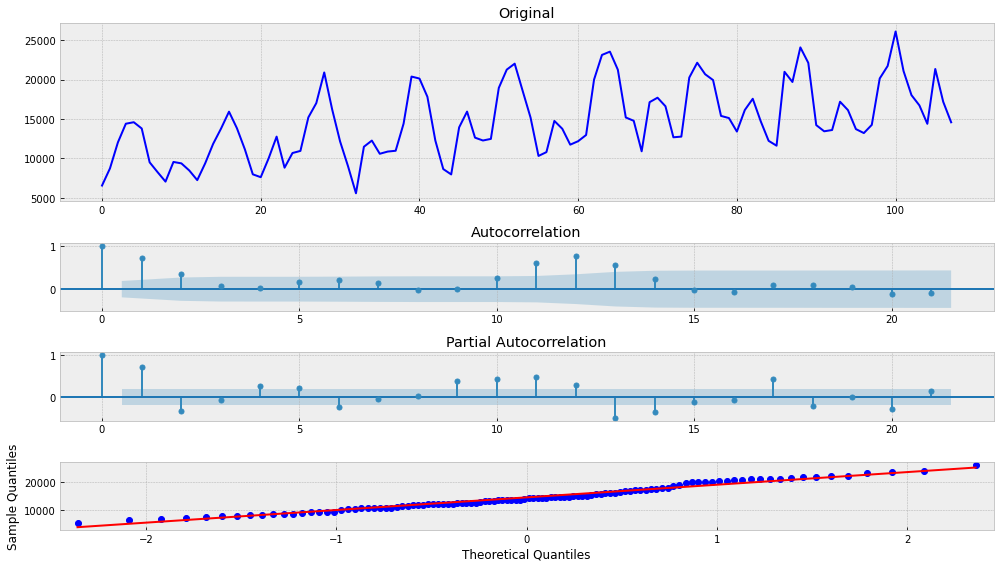

In [39]:
tsplot(car_sales)

Так как на графике видно, что временной ряд содержит и тренд, и сезонность, будем использовать модель SARIMA.

Подбираема гиперпараметры:

In [40]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

best_aic = np.inf 
best_order = None
best_seasonal_order = None
best_trend = None
best_mdl = None
t_params = ['n','c','t','ct']

for i in range(2):
    for d in range(2):
        for j in range(2):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        for trend in t_params:
                            try:
                                tmp_mdl = sm.tsa.statespace.SARIMAX(car_sales, order=(i, d, j), seasonal_order=(P, D, Q, 12), trend=trend).fit()
                                tmp_aic = tmp_mdl.aic
                                if tmp_aic < best_aic:
                                    best_aic = tmp_aic
                                    best_order = (i, d, j)
                                    best_seasonal_order = (P, D, Q)
                                    best_trend = trend
                                    best_mdl = tmp_mdl
                            except: continue


print('aic: {:6.5f} | order: {} | seasonal_order: {} | trend: {}'.format(best_aic, best_order, best_seasonal_order, best_trend))

E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


aic: 1682.34398 | order: (1, 1, 1) | seasonal_order: (0, 1, 1) | trend: c


In [41]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Count   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -836.172
Date:                            Sat, 14 Aug 2021   AIC                           1682.344
Time:                                    23:11:20   BIC                           1695.113
Sample:                                         0   HQIC                          1687.504
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -12.5882      4.007     -3.141      0.002     -20.442      -4.734
ar.L1          0.2656      0.107      2.487      0.013       0.056       0.475
ma.L1         -1.0000      0.155     -6.468      0.000      -1.303      -0.697
ma.S.L12      -0.5100      0.115     -4.443      0.000      -0.735      -0.285
sigma2      2.301e+06   1.03e-07   2.23e+13      0.000     2.3e+06     2.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.74   Prob(JB):                         0.56
Heteroskedasticity (H):               1.13   Skew:                             0.24
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.84e+30. Standard errors may be unstable.
"""

Параметры подобраны, строим прогноз:

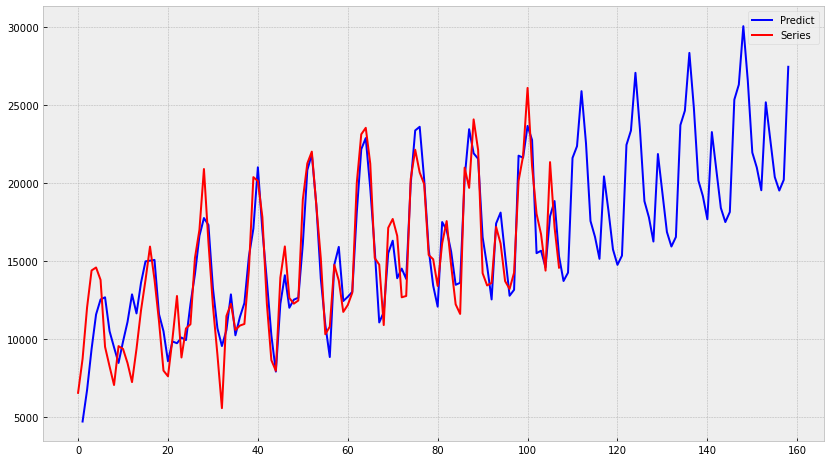

In [44]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    predict = tmp_mdl.predict(1, len(car_sales)+50, ax=ax)
    plt.plot(predict, color='blue', label='Predict')
    plt.plot(car_sales, color='red', label='Series')
    plt.legend()
    plt.show()

Выглядит неплохо, можно посмотреть распределение остатков:

Results of Dickey-Fuller Test:
Test Statistic                -8.246023e+00
p-value                        5.551367e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


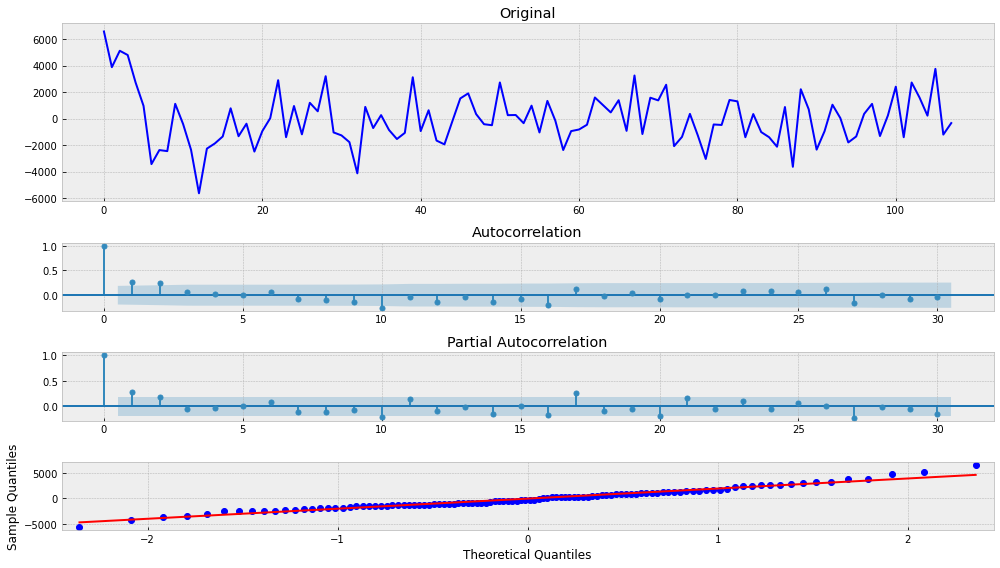

In [46]:
tsplot(best_mdl.resid, lags=30)

### Дополнительное задание: попробуйте спрогнозировать график классическим ML

In [48]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [51]:
X_train, X_test, y_train, y_test = prepareData(car_sales_df, lag_start=1, lag_end=10, test_size=0.3)

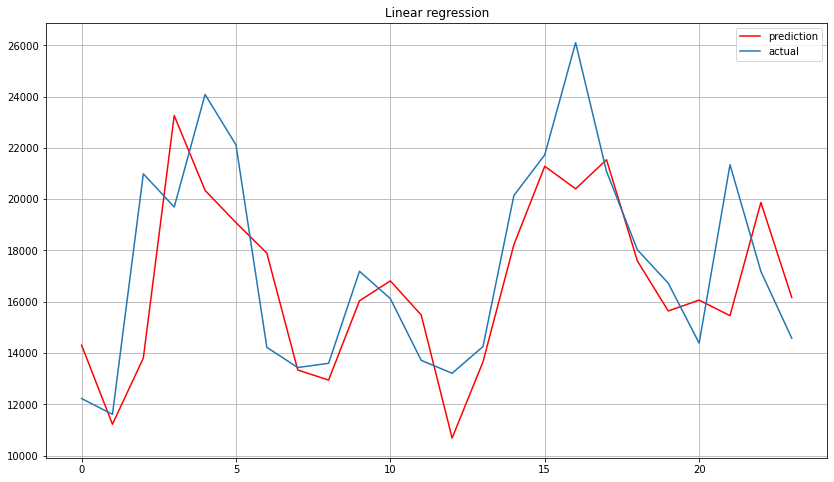

In [52]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);